In [1]:
!pip install ultralytics

# Importation des bibliothèques nécessaires



In [31]:
# Importation des bibliothèques utiles pour le traitement, l'affichage et les modèles
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from ultralytics import YOLO
import time


# Chargement de l’image

In [32]:
# Chargement de l'image à analyser
image = cv2.imread("/content/image_test.jpg")        # Chargement avec OpenCV
height, width, channels = image.shape

# Affichage des dimensions de l'image
print(f"Dimensions : {width}x{height}, Canaux : {channels}")


Dimensions : 4160x6240, Canaux : 3


# Fonction utilitaire pour affichage et sauvegarde

In [33]:
#  Fonction utilitaire pour afficher et sauvegarder une image annotée
def afficher_image(image, title, filename):
    cv2.imwrite(f"resultats/{filename}", image)  #  Sauvegarde dans le dossier "resultats"
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  #  Conversion BGR -> RGB pour affichage
    plt.title(title)
    plt.axis("off")
    plt.show()


# Détection avec YOLOv8


0: 640x448 2 persons, 1 cup, 1 potted plant, 1 dining table, 179.2ms
Speed: 8.4ms preprocess, 179.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)
 YOLOv8 : 3 objets détectés en 0.28 sec.


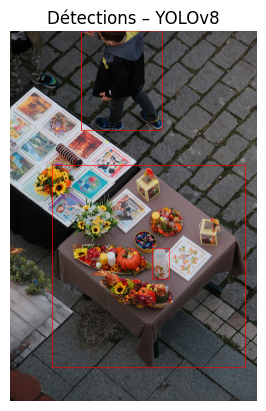

In [34]:
# Détection d'objets avec le modèle YOLOv8n (Ultralytics)
model_yolo = YOLO("yolov8n.pt")  # Chargement du modèle léger

start = time.time()
results_yolo = model_yolo(image)[0]  #  Inférence sur l'image
end = time.time()

#  Filtrage des détections avec un seuil de confiance > 0.5
seuil_confiance = 0.5
detections_yolo = [box for box in results_yolo.boxes.data if box[4] > seuil_confiance]

print(f" YOLOv8 : {len(detections_yolo)} objets détectés en {end - start:.2f} sec.")

#  Dessin des boîtes englobantes sur l'image (copie)
image_yolo = image.copy()
for box in detections_yolo:
    x1, y1, x2, y2, conf, cls = box[:6]
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    label = model_yolo.names[int(cls)]
    label = model_yolo.names[int(cls)]
    cv2.rectangle(image_yolo, (x1, y1), (x2, y2), (0, 0, 255), thickness=10)
    cv2.putText(image_yolo, f"{label} {conf:.2f}", (x1, max(y1 - 10, 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

#  Affichage + sauvegarde
afficher_image(image_yolo, "Détections – YOLOv8", "resultat_yolov8.jpg")


# Détection avec SSD MobileNet (TensorFlow Hub)

In [35]:
# Détection d'objets avec SSD MobileNet V2 depuis TensorFlow Hub
model_ssd = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

#  Prétraitement : chargement avec TensorFlow, redimensionnement, conversion type
image_tf = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
image_resized = tf.image.resize_with_pad(image_tf, 320, 320)
image_input = tf.expand_dims(tf.cast(image_resized, dtype=tf.uint8), axis=0)

start = time.time()
results_ssd = model_ssd(image_input)  #  Inférence avec SSD
end = time.time()

#  Extraction des prédictions
boxes = results_ssd["detection_boxes"].numpy()[0]
scores = results_ssd["detection_scores"].numpy()[0]
classes = results_ssd["detection_classes"].numpy()[0].astype(int)

print(f" SSD : {sum(scores >= seuil_confiance)} objets détectés en {end - start:.2f} sec.")


 SSD : 8 objets détectés en 9.33 sec.


# Affichage des résultats SSD

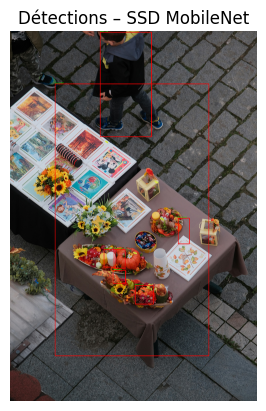

In [36]:
#  Dessin des boîtes englobantes sur une copie de l'image
image_ssd = image.copy()
for i in range(len(boxes)):
    if scores[i] >= seuil_confiance:
        y1, x1, y2, x2 = boxes[i]
        x1, y1, x2, y2 = int(x1 * width), int(y1 * height), int(x2 * width), int(y2 * height)
        label = f"Classe {classes[i]} {scores[i]:.2f}"
        cv2.rectangle(image_ssd, (x1, y1), (x2, y2), (0, 0, 255), thickness = 10)
        cv2.putText(image_ssd, label, (x1, max(y1 - 10, 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

#  Affichage + sauvegarde
afficher_image(image_ssd, "Détections – SSD MobileNet", "resultat_ssd_mobilenet.jpg")


# Résumé comparatif

In [37]:
#  Résumé des performances des deux modèles
print("=== Résumé comparatif ===")
print(f"YOLOv8 ➜ {len(detections_yolo)} objets détectés | Temps : {end - start:.2f} sec")
print(f"SSD MobileNet ➜ {sum(scores >= seuil_confiance)} objets détectés | Temps : {end - start:.2f} sec")


=== Résumé comparatif ===
YOLOv8 ➜ 3 objets détectés | Temps : 9.33 sec
SSD MobileNet ➜ 8 objets détectés | Temps : 9.33 sec
